In [1]:
import torch
import numpy as np
import os

import torchvision
from torch.utils.data import DataLoader
from torch.backends import mps
import matplotlib.pyplot as plt

In [4]:
img_dim = 224
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_dim, img_dim)), # Resize the image to 224x224
    torchvision.transforms.Grayscale(num_output_channels=1), # Convert the image to grayscale
    torchvision.transforms.ToTensor(), # Convert the image to a pytorch tensor
    torchvision.transforms.GaussianBlur(kernel_size=5), # Apply Gaussian Blur with kernel size 
])

In [5]:
# setup some path variables
project_path = './'

data_path =  '/teamspace/studios/this_studio/datascienceHealth/Train_Test_Folder/'
# Define train / test dataset
train_dataset = torchvision.datasets.ImageFolder(data_path + 'train/', transform=image_transform)
test_dataset = torchvision.datasets.ImageFolder(data_path + 'test/', transform=image_transform)

# Check the classes labels
class_labels = train_dataset.classes
print(class_labels)
# Check the number of samples in the train and test dataset
print('Number of images in train set:', len(train_dataset))
print('Number of images in test set:', len(test_dataset))

['Normal', 'Squamous Cell Carcinoma']
Number of images in train set: 7000
Number of images in test set: 3002


In [7]:
from sklearn.model_selection import train_test_split

# get the class names
class_names = train_dataset.classes
# Create a list of indices of the train dataset (used in the splits)
dataset_indices = np.arange(len(train_dataset))

# Split data into train and validation randomly
# randomly select 30% of the original train data for validation
train_indices, val_indices = train_test_split(dataset_indices, test_size=0.3)
# print(train_indices.shape)
# print(val_indices.shape)

# create train and validation datasets
new_train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
new_val_dataset = torch.utils.data.Subset(train_dataset, val_indices)

# Check the number of samples in the train and test dataset
print('Number of images in train set:', len(new_train_dataset))
print('Number of images in val set:', len(new_val_dataset))
print('Number of images in test set:', len(test_dataset))

Number of images in train set: 4900
Number of images in val set: 2100
Number of images in test set: 3002


In [6]:
# Check the classes labels
class_labels = train_dataset.classes
train_targets = np.array(train_dataset.targets) # get the targets for each image
# get weight for each class
class_weights = 1.0 / np.bincount(train_targets) # compute the class weights
class_weights = class_weights / class_weights.sum() # normalize the class weights
print('Class: ' +  ', '.join('%5s' % class_labels[i] for i in range(len(class_labels))))
print('Count: ' + str(np.bincount(train_targets)))
print('Weights: ' + str(class_weights))


Class: Normal, Squamous Cell Carcinoma
Count: [3500 3500]
Weights: [0.5 0.5]


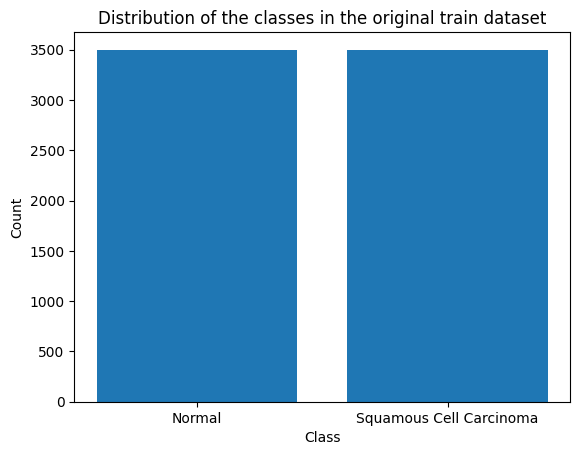

In [8]:
train_labels = np.array(train_dataset.targets)

# barplot the distribution of the labels
class_names = train_dataset.classes
class_counts = [np.sum(train_labels == i) for i in range(len(class_names))]
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of the classes in the original train dataset')
plt.show()

Image Shape: torch.Size([1, 224, 224])
Label: Normal


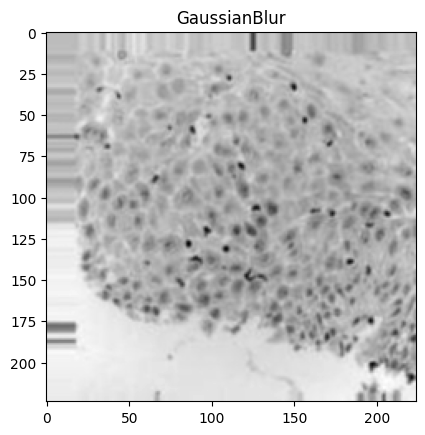

In [9]:
def imshow_gray(img, title=None):
  ''' function to show image '''
  plt.imshow(img.permute(1, 2, 0), cmap='gray')
  if title is not None:
    plt.title(title)
  plt.show()
# Define train / test dataset
train_dataset = torchvision.datasets.ImageFolder(data_path + 'train/', transform=image_transform)

# Show sample image
sample_idx = 240
sample_image, sample_label = train_dataset[sample_idx]
print(f'Image Shape: {sample_image.shape}')
print(f'Label: {class_labels[sample_label]}')

imshow_gray(sample_image, title='GaussianBlur')

Shape of image tensors: torch.Size([8, 1, 224, 224])
Shape of label tensors: torch.Size([8])


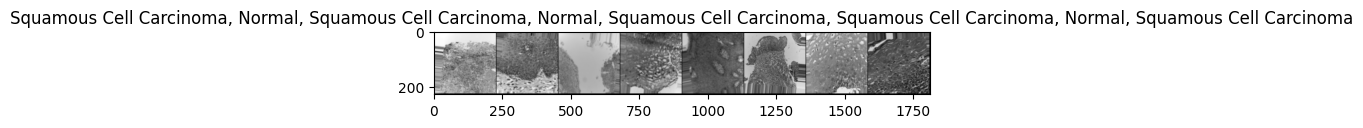

Squamous Cell Carcinoma, Normal, Squamous Cell Carcinoma, Normal, Squamous Cell Carcinoma, Squamous Cell Carcinoma, Normal, Squamous Cell Carcinoma
['Squamous Cell Carcinoma', 'Normal', 'Squamous Cell Carcinoma', 'Normal', 'Squamous Cell Carcinoma', 'Squamous Cell Carcinoma', 'Normal', 'Squamous Cell Carcinoma']


In [10]:
def imshow(img, title=None):
  ''' function to show image '''
  plt.imshow(img.permute(1, 2, 0))
  if title is not None:
    plt.title(title)
  plt.show()
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get a batch of images and labels
images, labels = next(iter(train_loader))
print(f'Shape of image tensors: {images.shape}')
print(f'Shape of label tensors: {labels.shape}')

# Display the batch of images
class_labels_string = ', '.join([class_labels[label] for label in labels]) # Create a string of class labels indexed by labels
imshow(torchvision.utils.make_grid(images), title = class_labels_string)
# plt.title(class_labels_string)

print(class_labels_string)

print([class_labels[label] for label in labels])

Shape of image tensors: torch.Size([8, 1, 224, 224])
Shape of label tensors: torch.Size([8])


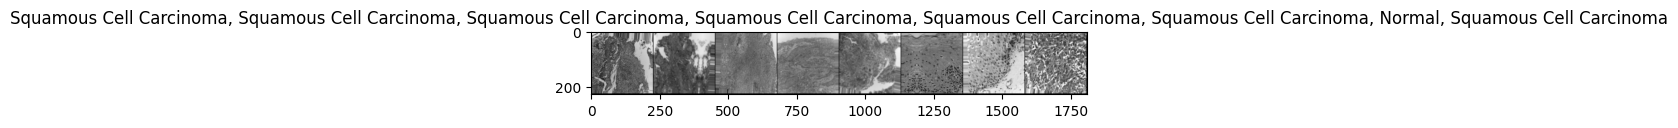

In [11]:
# # Define the data loader
batch_size = 8
train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(new_val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# get a batch of images and labels
images, labels = next(iter(train_loader))
print(f'Shape of image tensors: {images.shape}')
print(f'Shape of label tensors: {labels.shape}')

# Display the batch of images
class_labels_string = ', '.join([class_names[label] for label in labels]) # Create a string of class labels indexed by labels
imshow(torchvision.utils.make_grid(images), title = class_labels_string)
# plt.title(class_labels_string)

In [12]:
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu

class testmodel(nn.Module):

  def __init__(self, num_classes=2):
    super(testmodel, self).__init__()

    # convolutional layer 1 & max pool layer 1
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    # convolutional layer 2 & max pool layer 2
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    
    self.layer4 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    #Fully connected layer
    self.fc = nn.Sequential(
        nn.Linear(128*11*11, num_classes),
       
    )
  # Feed forward the network
  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = out.reshape(out.size(0), -1)
      out = self.fc(out)
      return out

In [13]:
# Define the model
net = testmodel()
print(net)

testmodel(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=15488, out_features=2, bias=True)
  )
)


In [14]:
batch_size = 8
train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(new_val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
import torch
import numpy as np

import torchvision
from torch.utils.data import DataLoader
from torch.backends import mps
import torch.optim as optim
import matplotlib.pyplot as plt

import time

# define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

num_epochs = 50 # loop over the dataset multiple times
start_time = time.time()

train_loss = []
val_loss = []
best_val_loss = np.inf
lr_list = []


for epoch in range(num_epochs): # one epoch is a complete pass through the train dataset
    
    # Training Model
    epoch_loss = 0.0
    for batch_index, data in enumerate(train_loader):
        images, labels = data # get the inputs; data is a list of [inputs, labels]
        # inputs.shape, labels.shape
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        epoch_loss += loss.item()
    
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Epoch: {epoch}, Loss: {epoch_loss/len(train_loader)}') # print the loss every epoch

    # Validation
    val_epoch_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item()
        
        val_loss.append(val_epoch_loss/len(val_loader))
        print(f'Validation Loss: {val_epoch_loss/len(val_loader)}')

        # call lr scheduler to check for plateau
        scheduler.step(val_epoch_loss)
        lr_list.append(optimizer.param_groups[0]['lr'])
        
        # save the model with the best validation loss
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_epoch = epoch
            torch.save(net.state_dict(), project_path + 'oral_cancer.pth')

end_time = time.time()
execution_time = end_time - start_time
print(f"Training completed in {execution_time} seconds")
print(f"Best validation loss: {best_val_loss/len(val_loader)} at epoch {best_epoch}")

Epoch: 0, Loss: 0.6912637565886605
Validation Loss: 0.6852328673061763
Epoch: 1, Loss: 0.6855985280156719
Validation Loss: 0.6953451755835529
Epoch: 2, Loss: 0.6777077870015025
Validation Loss: 0.6965849511750297
Epoch: 3, Loss: 0.6705836907977186
Validation Loss: 0.6601243946035552
Epoch: 4, Loss: 0.6618205638538566
Validation Loss: 0.6565113895972872
Epoch: 5, Loss: 0.6539592342314479
Validation Loss: 0.6565167395107646
Epoch: 6, Loss: 0.6505241671646983
Validation Loss: 0.6513590722029653
Epoch: 7, Loss: 0.644943296228692
Validation Loss: 0.660444318341665
Epoch: 8, Loss: 0.6419757628907582
Validation Loss: 0.6535544052096828
Epoch: 9, Loss: 0.6355677495967311
Validation Loss: 0.643715429668644
Epoch: 10, Loss: 0.6286859718465883
Validation Loss: 0.6424905735956852
Epoch: 11, Loss: 0.6178333369884367
Validation Loss: 0.6344189821767263
Epoch: 12, Loss: 0.6056428295461428
Validation Loss: 0.6340030003409876
Epoch: 13, Loss: 0.5859965498256839
Validation Loss: 0.6257488282234497
Epoch

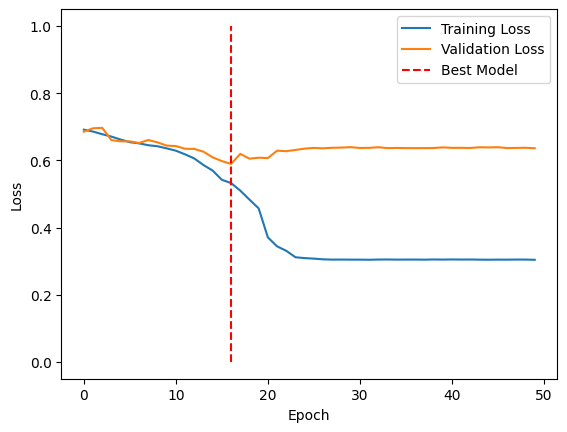

In [16]:
# plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.vlines(best_epoch, 0, 1, colors='r', linestyles='dashed', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

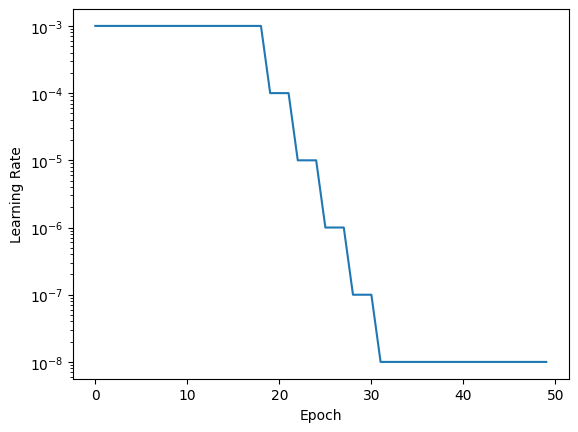

In [17]:
# plot the learning rate with log scale
plt.plot(lr_list)
plt.yscale('log') 
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

In [18]:
# reload saved model
net.load_state_dict(torch.load(project_path + 'oral_cancer.pth'))
# Test the model
correct = 0
total = 0
test_labels = np.array([])
test_predictions = np.array([])

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images, labels
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        # collect labels and predictions
        test_labels = np.concatenate((test_labels, labels.cpu().numpy()))
        test_predictions = np.concatenate((test_predictions, predicted.cpu().numpy()))
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

Accuracy of the network on the 3002 test images: 68 %


0.6818787475016655


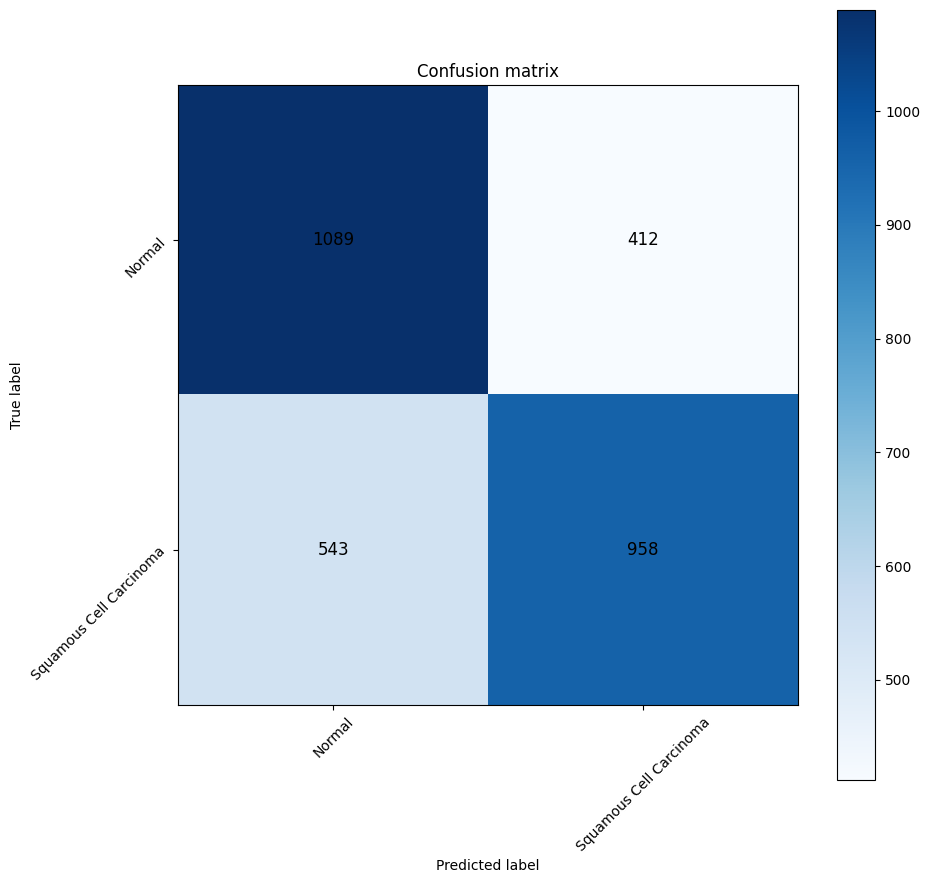

In [19]:
import sklearn.metrics

# compute score metrics
cm = sklearn.metrics.confusion_matrix(test_labels, test_predictions)
class_report = sklearn.metrics.classification_report(test_labels, test_predictions, target_names=class_names, output_dict=True)
balanced_acc = print(class_report['macro avg']['recall'])


# plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=45)
# Add numbers in the fields of the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Accuracy of the network on the 9006 test images: 68 %


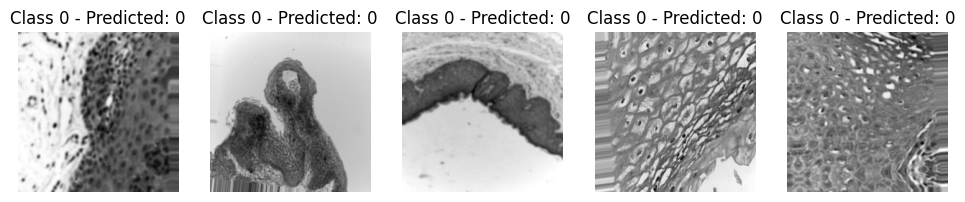

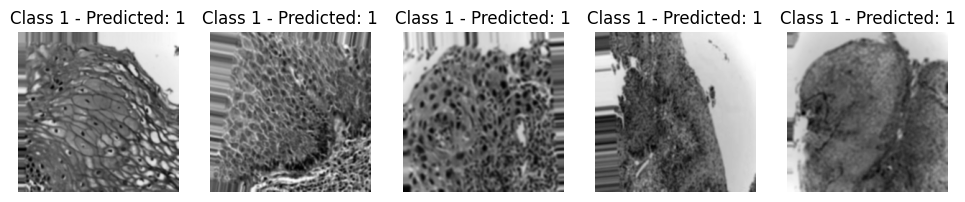

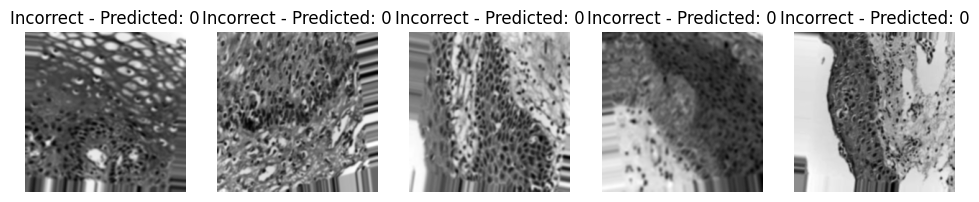

In [21]:
net = testmodel()
net.load_state_dict(torch.load(project_path + 'oral_cancer.pth'))

correct_images_class0 = []
correct_labels_class0 = []
correct_images_class1 = []
correct_labels_class1 = []
incorrect_images = []
incorrect_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Check which images were classified correctly and incorrectly
        for i in range(len(predicted)):
            if predicted[i] == labels[i]:
                if labels[i] == 0:
                    correct_images_class0.append(images[i])
                    correct_labels_class0.append(labels[i])
                elif labels[i] == 1:
                    correct_images_class1.append(images[i])
                    correct_labels_class1.append(labels[i])
            else:
                incorrect_images.append(images[i])
                incorrect_labels.append(labels[i])

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

# Display correctly classified images from class 0
num_images_to_display_class0 = min(5, len(correct_images_class0))
fig, axes = plt.subplots(1, num_images_to_display_class0, figsize=(12, 3))
for i in range(num_images_to_display_class0):
    ax = axes[i]
    ax.imshow(correct_images_class0[i].permute(1, 2, 0), cmap='gray')  # permute to (height, width, channels)
    ax.set_title(f'Class 0 - Predicted: {correct_labels_class0[i]}')
    ax.axis('off')
plt.show()

# Display correctly classified images from class 1
num_images_to_display_class1 = min(5, len(correct_images_class1))
fig, axes = plt.subplots(1, num_images_to_display_class1, figsize=(12, 3))
for i in range(num_images_to_display_class1):
    ax = axes[i]
    ax.imshow(correct_images_class1[i].permute(1, 2, 0), cmap='gray')  # permute to (height, width, channels)
    ax.set_title(f'Class 1 - Predicted: {correct_labels_class1[i]}')
    ax.axis('off')
plt.show()


# Display incorrectly classified images
num_images_to_display_incorrect = min(5, len(incorrect_images))
fig, axes = plt.subplots(1, num_images_to_display_incorrect, figsize=(12, 3))
for i in range(num_images_to_display_incorrect):
    ax = axes[i]
    ax.imshow(incorrect_images[i].permute(1, 2, 0), cmap='gray')  # permute to (height, width, channels)
    ax.set_title(f'Incorrect - Predicted: {incorrect_labels[i]}')
    ax.axis('off')
plt.show()